### imports

In [1]:
library(sf)
library(dplyr)
library(igraph)
library(visNetwork)
library(geosphere)
library(shiny)
library(htmlwidgets)
library(tidyr)     # unnest_longer
library(purrr)     # map2_dfr
library(lwgeom)
r_world <- 6378137

Linking to GEOS 3.11.2, GDAL 3.8.2, PROJ 9.3.1; sf_use_s2() is TRUE


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union



Attaching package: 'shiny'


The following object is masked from 'package:geosphere':

    span



Attaching package: 'tidyr'


The following object is masked from 'package:igraph':

    crossing



Attaching package: 'purrr'


The following objects are masked from 'package:igraph':

    compose, simplify


Linking to liblwgeom 3.0.0beta1 r16016, GEOS 3.11.2, PROJ 9.3.1


Attaching package: 'lwgeom'


The following object is masked from 'package:sf':

    

## Functions for Graph simplification

In [2]:
# funzione che data una edge list, restituisce 
# le coordinate della node list in formato dataframe (id, x, y)
assign_coord <- function(coord_dictionary, edge_list){
    
    # Estrai l'insieme unico dei nodi dagli archi
    # questa cosa da problemi nel caso in cui ci siano nodi isolati!!!
    node_list <- unique(as.vector(edge_list))

    # Filtra la lista delle coordinate dei vertici in base ai nodi presenti in node_set

    coord_list <- coord_dictionary[coord_dictionary$id %in% node_list,]
    return(coord_list)
}
# dato un grafo ( e gli id delle stazioni )
# restituisce i nodi del grafo 'ridondanti' e i due neighbors
# redundat nodes are degree 2 nodes that aren't stations, 
# for sure we can remove those and connect the 2 neighbors
find_redundancy_matrix <- function(graph, protected_nodes){

    redundant_id <- V(graph)[!(V(graph)$name %in% protected_nodes) & degree(graph) == 2]$name
    # Initialize a list to store the results
    neighbor_a <- c()
    neighbor_b <- c()
    
    # Loop through each redundant node and get its neighbors
    for(id in redundant_id) {
        #neighbors_id <- neighbors(graph, id)
        neighbor_a <- c(neighbor_a, as.double(neighbors(graph, id)[[1]]$name))
        neighbor_b <- c(neighbor_b, as.double(neighbors(graph, id)[[2]]$name))
    }
    
    redundancy_mat <- data.frame(as.double(redundant_id), neighbor_a, neighbor_b)
    return(as.matrix(redundancy_mat))
}

flip_index <- function(idx){
    if(idx == 1){
        return(2)
    }
    else if(idx == 2){
        return(1)
    }
}

# questa funzione si prende la redundancy matrix, un grafo e restituisce il grafo aggiornato 
# semplificato dall'algoritmo 
simplify_graph_one_step <- function(redundancy_matrix,  graph){

    edgelist <- as_edgelist(graph = graph, names = TRUE)
    redundant_nodes <- redundancy_matrix[,1]
    neighbors_mat <- redundancy_matrix[,2:3, drop = FALSE]#
    new_edge_list <- matrix(ncol = 2, nrow = 0) 

    # Trova e salva shortcut edge tra nodi non ridondanti
    for(i in 1:nrow(neighbors_mat)){
        for(j in 1:ncol(neighbors_mat)){

            #controlliamo se elemento è brutto 
            if((neighbors_mat[i,j] %in% redundant_nodes)){
                next
            }
            #se bello 
            else {
                #salva elemento
                new_edge_list <- rbind(new_edge_list, c(neighbors_mat[i,j],0)) 
                
                # vedi suo amico
                friend <- neighbors_mat[i,flip_index(j)]
                # cerca se esiste in ab il twin
                twin_index <- which(row(neighbors_mat) != i & neighbors_mat == friend, arr.ind = TRUE)
                # verifichiamo che friend sia ridondante e che il suo twin esista 
                condition <- friend %in% redundant_nodes && !is.na(twin_index[1])

                while(condition){
                    # aggiorniamo friend 
                    friend <- neighbors_mat[twin_index[1],flip_index(twin_index[2])]
                    i <- twin_index[1]
                    twin_index <- which(row(neighbors_mat) != i & neighbors_mat == friend, arr.ind = TRUE)
                    condition <- !is.na(twin_index[1]) && friend %in% redundant_nodes 
                }
                
                if(!(friend %in% redundant_nodes)){
                    new_edge_list[nrow(new_edge_list),2] <- friend 
                    
                }
                else if (is.na(twin_index[1])){
                    i_prime <- which(redundant_nodes == friend ,  arr.ind = TRUE)
                    row_elements <- neighbors_mat[i_prime,]
                    element <- row_elements[!row_elements %in% redundant_nodes]
                    new_edge_list[nrow(new_edge_list),2] <- (element)
                }
            }
        }
    }
        # Conserva gli edge tra due nodi non ridondanti
    for(i in 1:nrow(edgelist)){
        row_elements <- edgelist[i,]
        if(!any(row_elements %in% redundant_nodes)){
            new_edge_list <- rbind(new_edge_list, row_elements)
        }
    }
    return(unique(new_edge_list))
}

In [3]:
get_protected_nodes <- function(g, stations_id) {
  # 1) Stations are automatically protected
  prot <- stations_id
  
  # 2) Find all 3-cliques and mark their members
  tris <- cliques(g, min = 3, max = 3)
  tri_members <- unique(unlist(lapply(tris, function(tri) V(g)[tri]$name)))
  prot <- c(prot, tri_members)
  
  # 3) Find all nodes j with degree >= 3 that are NOT in any 3-clique
  degs <- degree(g)
  names(degs) <- V(g)$name
  high_deg <- names(degs)[degs >= 3]
  tri_members_deg3 <- setdiff(tri_members, names(degs)[degs >= 4])
  non_tri_high_deg <- setdiff(high_deg, tri_members_deg3)
  
  # 4) For each such j, include *all* of its neighbors
  nbrs <- unique(unlist(neighborhood(g, order = 1, nodes = non_tri_high_deg, mode = "all")) )
  nbrs <- V(g)[nbrs]$name
  
  # 5) Combine and unique
  unique(c(prot, nbrs))
}

In [4]:
simplify_graph <- function(graph){

    protected_nodes <- get_protected_nodes(g,stations_id)
    non_protected <- setdiff(V(graph)$name, protected_nodes)
    redundancy_matrix <- find_redundancy_matrix(graph, protected_nodes)  

    condition <- any(degree(graph, non_protected) == 2)
    graph_history <- list(graph)
    i <- 1

    while(condition){

        simplified_edge_list <- simplify_graph_one_step(redundancy_matrix, graph)

        vert <- as_data_frame(g, what = "vertices")
        used_names <- unique(c(simplified_edge_list[, 1], simplified_edge_list[, 2])
)      
        vert   <- vert %>%          
         filter(name %in% used_names)

        graph <- igraph::simplify(graph_from_data_frame(simplified_edge_list,
                                                 directed = F,vertices = vert))
        graph_history[[i+1]] <- graph

        protected_nodes <- get_protected_nodes(g,stations_id)
        non_protected <- setdiff(V(graph)$name, protected_nodes)
        redundancy_matrix <- find_redundancy_matrix(graph, protected_nodes)        
        
        condition <- any(degree(graph, non_protected)==2) & nrow(redundancy_matrix)!=0
        i <- i+1
    }
    cat('\n grafo semplificato :) !')
    return(graph_history)   
}


In [5]:
find_contractible_Ys <- function(g, stations_id, maxdist = 3) {
  # 1) candidate junctions: degree-3 & not a station
  degs      <- degree(g)
  candidates <- V(g)[degs == 3]$name
  
  triples <- list()
  
  for (j in candidates) {
    # 2) find other degree-3 nodes within distance ≤ maxdist
    others      <- setdiff(names(degs)[degs == 3], j)
    d_to_others <- distances(g, v = j, to = others)[1, ]
    close_nodes <- others[d_to_others <= maxdist]
    if (length(close_nodes) < 2) next
    
    # 3) examine every pair (k1,k2) among close_nodes
    for (pair in combn(close_nodes, 2, simplify = FALSE)) {
      k1 <- pair[1]; k2 <- pair[2]
      
      # 4) check pairwise distance
      if (distances(g, v = k1, to = k2)[1,1] > maxdist) next
      
      # 5) get the three shortest‐path vertex sequences
      paths <- list(
        p1 = shortest_paths(g, from = j,  to = k1, output = "vpath")$vpath[[1]],
        p2 = shortest_paths(g, from = j,  to = k2, output = "vpath")$vpath[[1]],
        p3 = shortest_paths(g, from = k1, to = k2,output = "vpath")$vpath[[1]]
      )
      
      # 6) verify each intermediate node on each path
      ok <- TRUE
      for (p in paths) {
        verts <- as_ids(p)
        if (length(verts) > 2) {
          mids <- verts[-c(1, length(verts))]
          # must not be a station, and must have degree 2
          if (any(mids %in% stations_id) ||
              any(degree(g, mids) != 2)) {
            ok <- FALSE
            break
          }
        }
      }
      if (ok) {
        triples[[length(triples) + 1]] <- c(j, k1, k2)
      }
    }
  }
  
  # dedupe and return
  unique(triples)
}

In [6]:
collapse_contractible_Ys <- function(g, stations_id, maxdist = 3) {
  triples <- find_contractible_Ys(g, stations_id, maxdist)
  g2      <- g

  for (tri in triples) {
    pairs <- combn(tri, 2, simplify = FALSE)

    # 1) Collect mids on the original g
    mids <- unique(unlist(lapply(pairs, function(p) {
      pth <- shortest_paths(
        g, from = p[1], to = p[2], output = "vpath"
      )$vpath[[1]]
      ids <- as_ids(pth)
      if (length(ids) > 2) ids[-c(1, length(ids))] else character(0)
    })))

    # 2) Add the missing clique‐edges to g2
    for (p in pairs) {
      if (!are.connected(g2, p[1], p[2])) {
        g2 <- add_edges(g2, c(p[1], p[2]))
      }
    }

    # 3) Only delete those mids that still exist in g2
    mids_to_rm <- intersect(mids, V(g2)$name)
    if (length(mids_to_rm)) {
      g2 <- delete_vertices(g2, mids_to_rm)
    }
  }

  # 4) final clean‐up
  igraph::simplify(g2)
}


## Data extraction

In [36]:
shp_path     <- "Data_task_45/EGM_2019_SHP_20190312/DATA/FullEurope/RailrdL.shp"
lines        <- st_read(shp_path, quiet = TRUE) 

# 2) Extract raw coords + feature-index
xy           <- st_coordinates(lines)   # columns: X, Y, L1

# 3) Pull out just the two attrs we want and tag them with L1
attrs_by_L1  <- lines %>%
                  st_drop_geometry() %>%      # drop geometry column
                  mutate(L1 = row_number()) %>% 
                  select(L1, ICC)

# 4) Build coord table and join attributes
coords_rail    <- as_tibble(xy) %>%         # X, Y, L1
                  left_join(attrs_by_L1, by = "L1") %>%
                  group_by(L1) %>%
                  mutate(
                    pos = row_number(),
                    n   = n()
                  ) %>%
                  ungroup()

# 1) Remove the big intermediate objects
rm(lines, xy)  
# 2) Run garbage‐collection
invisible(gc())

coords_rail_pruned <- coords_rail %>%
  filter(pos <= 2     # first two points
        | pos >= n - 1 # last two points
        )

In [37]:
shp_pts     <- "Data_task_45/EGM_2019_SHP_20190312/DATA/FullEurope/RailrdC.shp"
#shp_pts     <- "Data_task_45/EGM_2019_SHP_20190312/DATA/Countries/EE/RailrdC.shp"
# 2) Read & force to WGS‐84 lon/lat
stations_sf <- st_read(shp_pts, quiet = TRUE) 
#print(st_crs(stations_sf))
#print(unique(stations_sf$TFC))
# 3) Extract raw coords (X=lon, Y=lat)
xy_pts      <- st_coordinates(stations_sf)

# 4) Drop the geometry and grab only the attrs you care about
attrs       <- stations_sf %>%
  st_drop_geometry() %>%
  select(ICC, NAMN1, RStationID,TFC)

# 5) Assemble the stat_coords tibble
coords_stations <- tibble(
  lon          = xy_pts[, "X"],
  lat          = xy_pts[, "Y"]
) %>%
  bind_cols(attrs)

# 1) Remove the big intermediate objects
rm(stations_sf, xy_pts)  
# 2) Run garbage‐collection
invisible(gc())

coords_stations <- coords_stations %>%
  distinct() 

In [38]:
coords_rail_enriched <- coords_rail_pruned %>% #you can use the pruned or not pruned here
  # join on exact coordinate match
  left_join(
    coords_stations,
    by = c("X" = "lon", "Y" = "lat"),
    relationship = "many-to-many"
  )
coords_rail_enriched <- coords_rail_enriched %>%
  # drop the one we don’t want:
  select(-ICC.y) %>%        
  # rename the survivor to a single “ICC”:
  rename(ICC = ICC.x)       

In [39]:
nodes <- coords_rail_enriched %>%
  group_by(X, Y) %>%
  summarise(
    ICC    = list(sort(unique(ICC))),   # a list‐column of codes, e.g. c("ES","PT")
    NAMN1  = first(na.omit(NAMN1)) %||% NA_character_,
    .groups = "drop"
  ) %>%
  mutate(node_id = row_number())

# 2) Build the edge list ---------------------------------------------------

edges <- coords_rail_enriched %>%
  arrange(L1, pos) %>%         # ensure each L1 is in order
  group_by(L1) %>%
  mutate(
    X_to = lead(X),            # next‐point coords
    Y_to = lead(Y)
  ) %>%
  filter(!is.na(X_to)) %>%     # drop last point of each line (no lead)
  ungroup() %>%
  # now map coords → node_id
  left_join(nodes, by = c("X" = "X", "Y" = "Y")) %>%
  rename(from = node_id) %>%
  left_join(nodes, by = c("X_to" = "X", "Y_to" = "Y")) %>%
  rename(to   = node_id) %>%
  select(from, to)

# 3) Create the igraph object ----------------------------------------------

g <- graph_from_data_frame(
  d = edges,
  vertices = nodes %>% select(node_id, X, Y, NAMN1,ICC),
  directed = FALSE
)

g <- igraph::simplify( g,
  remove.multiple = TRUE,
  remove.loops    = TRUE)

In [40]:
coord_dictionary <- nodes %>%
  # rename X→x and Y→y so the plot fn picks them up
  transmute(
    id   = as.character(node_id),
    x    = X,
    y    = Y,
    NAMN1,
    ICC
  )
stations_id <- coord_dictionary %>%
  filter(!is.na(NAMN1)) %>%
  pull(id)

ciao

## Semplification Main

In [ ]:
non_protected <- V(g)[!(V(g)$name %in% get_protected_nodes(g,stations_id))]$name

condition <-any(degree(g,non_protected)==1)
while (condition){
    deg_one_nonprotected <- names(which(degree(g,non_protected)==1))
    g<- delete_vertices(g,deg_one_nonprotected)

    non_protected <- V(g)[!(V(g)$name %in% get_protected_nodes(g,stations_id))]$name
    condition <-any(degree(g,non_protected)==1)
}
graphs<-simplify_graph(g)
k= length(graphs)

In [ ]:
new_g <-collapse_contractible_Ys(g = graphs[[k]],stations_id = stations_id,maxdist = 3)

In [ ]:
final_gs <-simplify_graph(new_g)
t= length(final_gs)
final_g <- final_gs[[t]]


 grafo semplificato :) !

In [ ]:
non_protected <- V(final_g)[!(V(final_g)$name %in% get_protected_nodes(final_g,stations_id))]$name

condition <-any(degree(final_g,non_protected)==1)
while (condition){
    deg_one_nonprotected <- names(which(degree(final_g,non_protected)==1))
    final_g<- delete_vertices(final_g,deg_one_nonprotected)

    non_protected <- V(final_g)[!(V(final_g)$name %in% get_protected_nodes(final_g,stations_id))]$name
    condition <-any(degree(final_g,non_protected)==1)
}

In [ ]:
library(countrycode)   # iso-2/iso-3 ⇄ country names
## ── 1.  NODES TABLE ──────────────────────────────────────────────────────
nodes_df <- as_data_frame(final_g, what = "vertices") %>%
  transmute(
    nodeID        = name,             # keep igraph vertex name
    nodeLabel     = NAMN1,            # may be NA
    latitude      = Y,
    longitude     = X,
    iso2          = map_chr(ICC, ~ .x[[1]] %||% NA_character_),   # first code
    country_ISO3  = countrycode(iso2, "iso2c", "iso3c"),
    country_name  = countrycode(country_ISO3, "iso3c", "country.name")
  ) %>%
  select(nodeID, nodeLabel, latitude, longitude,
         country_name, country_ISO3)

## OPTIONAL: pick one country’s rows, e.g. Spain/Portugal only
# nodes_df <- nodes_df %>% filter(iso2 %in% c("ES","PT"))

## ── 2.  EDGES TABLE ──────────────────────────────────────────────────────
edges_df <- as_data_frame(final_g, what = "edges") %>%
  transmute(
    nodeID_from = from,     # already vertex names
    nodeID_to   = to
  )

## OPTIONAL: keep only edges whose endpoints are in nodes_df
# edges_df <- edges_df %>%
#   semi_join(nodes_df,    by = c("nodeID_from" = "nodeID")) %>%
#   semi_join(nodes_df,    by = c("nodeID_to"   = "nodeID"))

## ── 3.  WRITE TO DISK ────────────────────────────────────────────────────
write.csv(nodes_df, "results/FullEurope_nodes.csv",  row.names = FALSE, na = "")
write.csv(edges_df, "results/FullEurope_edges.csv",  row.names = FALSE)

In [35]:
countries <- c("AL","AT","BE","BG","CHLI","CY","CZ","DE","DK",
               "EE","ES","FI","FR","GB","GE","GR","HR","HU",
               "IE","IS")

# 2) iterate ---------------------------------------------------------------
for (icc in countries) {

  shp_pts <- file.path(
    "Data_task_45/EGM_2019_SHP_20190312",
    "DATA","Countries", icc, "RailrdC.shp")

  if (!file.exists(shp_pts)) {
    warning("missing file: ", shp_pts)
    next                      # skip to next code
  }

  shp_rail <- file.path(
    "Data_task_45/EGM_2019_SHP_20190312",
    "DATA","Countries", icc, "RailrdL.shp")

  if (!file.exists(shp_rail)) {
    warning("missing file: ", shp_rail)
    next                      # skip to next code
  }


  message("• reading ", icc, " …")

lines        <- st_read(shp_rail, quiet = TRUE) 

# 2) Extract raw coords + feature-index
xy           <- st_coordinates(lines)   # columns: X, Y, L1

# 3) Pull out just the two attrs we want and tag them with L1
attrs_by_L1  <- lines %>%
                  st_drop_geometry() %>%      # drop geometry column
                  mutate(L1 = row_number()) %>% 
                  select(L1, ICC)

# 4) Build coord table and join attributes
coords_rail    <- as_tibble(xy) %>%         # X, Y, L1
                  left_join(attrs_by_L1, by = "L1") %>%
                  group_by(L1) %>%
                  mutate(
                    pos = row_number(),
                    n   = n()
                  ) %>%
                  ungroup()

# 1) Remove the big intermediate objects
rm(lines, xy)  
# 2) Run garbage‐collection
invisible(gc())

coords_rail_pruned <- coords_rail %>%
  filter(pos <= 2     # first two points
        | pos >= n - 1 # last two points
        )

# 2) Read & force to WGS‐84 lon/lat
stations_sf <- st_read(shp_pts, quiet = TRUE) 
#print(st_crs(stations_sf))
#print(unique(stations_sf$TFC))
# 3) Extract raw coords (X=lon, Y=lat)
xy_pts      <- st_coordinates(stations_sf)

# 4) Drop the geometry and grab only the attrs you care about
attrs       <- stations_sf %>%
  st_drop_geometry() %>%
  select(ICC, NAMN1, RStationID,TFC)

# 5) Assemble the stat_coords tibble
coords_stations <- tibble(
  lon          = xy_pts[, "X"],
  lat          = xy_pts[, "Y"]
) %>%
  bind_cols(attrs)

# 1) Remove the big intermediate objects
rm(stations_sf, xy_pts)  
# 2) Run garbage‐collection
invisible(gc())

coords_stations <- coords_stations %>%
  distinct() 

coords_rail_enriched <- coords_rail_pruned %>% #you can use the pruned or not pruned here
  # join on exact coordinate match
  left_join(
    coords_stations,
    by = c("X" = "lon", "Y" = "lat"),
    relationship = "many-to-many"
  )
coords_rail_enriched <- coords_rail_enriched %>%
  # drop the one we don’t want:
  select(-ICC.y) %>%        
  # rename the survivor to a single “ICC”:
  rename(ICC = ICC.x)       

  nodes <- coords_rail_enriched %>%
  group_by(X, Y) %>%
  summarise(
    ICC    = list(sort(unique(ICC))),   # a list‐column of codes, e.g. c("ES","PT")
    NAMN1  = first(na.omit(NAMN1)) %||% NA_character_,
    .groups = "drop"
  ) %>%
  mutate(node_id = row_number())

# 2) Build the edge list ---------------------------------------------------

edges <- coords_rail_enriched %>%
  arrange(L1, pos) %>%         # ensure each L1 is in order
  group_by(L1) %>%
  mutate(
    X_to = lead(X),            # next‐point coords
    Y_to = lead(Y)
  ) %>%
  filter(!is.na(X_to)) %>%     # drop last point of each line (no lead)
  ungroup() %>%
  # now map coords → node_id
  left_join(nodes, by = c("X" = "X", "Y" = "Y")) %>%
  rename(from = node_id) %>%
  left_join(nodes, by = c("X_to" = "X", "Y_to" = "Y")) %>%
  rename(to   = node_id) %>%
  select(from, to)

# 3) Create the igraph object ----------------------------------------------

g <- graph_from_data_frame(
  d = edges,
  vertices = nodes %>% select(node_id, X, Y, NAMN1,ICC),
  directed = FALSE
)

g <- igraph::simplify( g,
  remove.multiple = TRUE,
  remove.loops    = TRUE)

  coord_dictionary <- nodes %>%
  # rename X→x and Y→y so the plot fn picks them up
  transmute(
    id   = as.character(node_id),
    x    = X,
    y    = Y,
    NAMN1,
    ICC
  )

stations_id <- coord_dictionary %>%
  filter(!is.na(NAMN1)) %>%
  pull(id)



  # NOw start simplyfying




non_protected <- V(g)[!(V(g)$name %in% get_protected_nodes(g,stations_id))]$name

condition <-any(degree(g,non_protected)==1)
while (condition){
    deg_one_nonprotected <- names(which(degree(g,non_protected)==1))
    g<- delete_vertices(g,deg_one_nonprotected)

    non_protected <- V(g)[!(V(g)$name %in% get_protected_nodes(g,stations_id))]$name
    condition <-any(degree(g,non_protected)==1)
}
graphs<-simplify_graph(g)
k= length(graphs)



  new_g <-collapse_contractible_Ys(g = graphs[[k]],stations_id = stations_id,maxdist = 3)

  final_gs <-simplify_graph(new_g)
t= length(final_gs)
final_g <- final_gs[[t]]


non_protected <- V(final_g)[!(V(final_g)$name %in% get_protected_nodes(final_g,stations_id))]$name

condition <-any(degree(final_g,non_protected)==1)
while (condition){
    deg_one_nonprotected <- names(which(degree(final_g,non_protected)==1))
    final_g<- delete_vertices(final_g,deg_one_nonprotected)

    non_protected <- V(final_g)[!(V(final_g)$name %in% get_protected_nodes(final_g,stations_id))]$name
    condition <-any(degree(final_g,non_protected)==1)
}


library(countrycode)   # iso-2/iso-3 ⇄ country names
## ── 1.  NODES TABLE ──────────────────────────────────────────────────────
nodes_df <- as_data_frame(final_g, what = "vertices") %>%
  transmute(
    nodeID        = name,             # keep igraph vertex name
    nodeLabel     = NAMN1,            # may be NA
    latitude      = Y,
    longitude     = X,
    iso2          = map_chr(ICC, ~ .x[[1]] %||% NA_character_),   # first code
    country_ISO3  = countrycode(iso2, "iso2c", "iso3c"),
    country_name  = countrycode(country_ISO3, "iso3c", "country.name")
  ) %>%
  select(nodeID, nodeLabel, latitude, longitude,
         country_name, country_ISO3)

## OPTIONAL: pick one country’s rows, e.g. Spain/Portugal only
# nodes_df <- nodes_df %>% filter(iso2 %in% c("ES","PT"))

## ── 2.  EDGES TABLE ──────────────────────────────────────────────────────
edges_df <- as_data_frame(final_g, what = "edges") %>%
  transmute(
    nodeID_from = from,     # already vertex names
    nodeID_to   = to
  )

## OPTIONAL: keep only edges whose endpoints are in nodes_df
# edges_df <- edges_df %>%
#   semi_join(nodes_df,    by = c("nodeID_from" = "nodeID")) %>%
#   semi_join(nodes_df,    by = c("nodeID_to"   = "nodeID"))

## ── 3.  WRITE TO DISK ────────────────────────────────────────────────────

  write.csv(nodes_df,
            file = file.path("results", paste0(icc, "_nodes.csv")),
            row.names = FALSE, na = "")

  write.csv(edges_df,
            file = file.path("results", paste0(icc, "_edges.csv")),
            row.names = FALSE)

  message("wrote ", icc, "_nodes.csv and _edges.csv")

}

Warning message in eval(expr, envir, enclos):
"missing file: Data_task_45/EGM_2019_SHP_20190312/DATA/Countries/AL/RailrdC.shp"
• reading AT …




 grafo semplificato :) !
 grafo semplificato :) !

wrote AT_nodes.csv and _edges.csv

• reading BE …




 grafo semplificato :) !
 grafo semplificato :) !

wrote BE_nodes.csv and _edges.csv

• reading BG …




 grafo semplificato :) !
 grafo semplificato :) !

wrote BG_nodes.csv and _edges.csv

• reading CHLI …




 grafo semplificato :) !
 grafo semplificato :) !

wrote CHLI_nodes.csv and _edges.csv

Warning message in eval(expr, envir, enclos):
"missing file: Data_task_45/EGM_2019_SHP_20190312/DATA/Countries/CY/RailrdC.shp"
• reading CZ …




 grafo semplificato :) !
 grafo semplificato :) !

wrote CZ_nodes.csv and _edges.csv

• reading DE …




 grafo semplificato :) !
 grafo semplificato :) !

wrote DE_nodes.csv and _edges.csv

• reading DK …




 grafo semplificato :) !
 grafo semplificato :) !

wrote DK_nodes.csv and _edges.csv

• reading EE …




 grafo semplificato :) !
 grafo semplificato :) !

wrote EE_nodes.csv and _edges.csv

• reading ES …




 grafo semplificato :) !
 grafo semplificato :) !

wrote ES_nodes.csv and _edges.csv

• reading FI …




 grafo semplificato :) !
 grafo semplificato :) !

wrote FI_nodes.csv and _edges.csv

• reading FR …




 grafo semplificato :) !
 grafo semplificato :) !

wrote FR_nodes.csv and _edges.csv

• reading GB …




 grafo semplificato :) !
 grafo semplificato :) !

wrote GB_nodes.csv and _edges.csv

• reading GE …




 grafo semplificato :) !
 grafo semplificato :) !

wrote GE_nodes.csv and _edges.csv

• reading GR …




 grafo semplificato :) !
 grafo semplificato :) !

wrote GR_nodes.csv and _edges.csv

• reading HR …




 grafo semplificato :) !
 grafo semplificato :) !

wrote HR_nodes.csv and _edges.csv

• reading HU …




 grafo semplificato :) !
 grafo semplificato :) !

wrote HU_nodes.csv and _edges.csv

• reading IE …




 grafo semplificato :) !
 grafo semplificato :) !

wrote IE_nodes.csv and _edges.csv

Warning message in eval(expr, envir, enclos):
"missing file: Data_task_45/EGM_2019_SHP_20190312/DATA/Countries/IS/RailrdC.shp"


in theory those operations leave the door open for conditionS to become true again, ma il grosso è fatto

### convert to CSV to export

## Plot

### functions

In [33]:
assign_coord_modificata <- function(coord_dictionary, graph){
    # Estrai l'insieme unico dei nodi dal grafo, inclusi i nodi isolati
    node_list <- V(graph)$name #qui

    # Filtra la lista delle coordinate dei vertici in base ai nodi presenti nel grafo
    coord_list <- coord_dictionary[coord_dictionary$id %in% node_list,]
    return(coord_list)
}

plot_graph_modificata <- function(graph, id_stations, coord_dictionary, wid, hei, res){

    vert <- assign_coord_modificata(coord_dictionary = coord_dictionary, graph)
    
    isolated_clusters_info <-components(graph)$membership
    number_of_clusters <- components(graph)$no 

    color_list <- sample(colors(), number_of_clusters, replace = FALSE)

    for (z in 1:number_of_clusters){
        cluster_members <- names(which(isolated_clusters_info == z)) # nome dei nodi che appartengono al cluster z
        
        V(graph)[name %in% cluster_members]$color <- color_list[z]

    }

    layout <- matrix(NA, length(vert$x), 2)
    layout[,1] <- vert$x
    layout[,2] <- vert$y
    
    options(repr.plot.width = wid, repr.plot.height = hei, repr.plot.res = res)

    plot(graph,
         layout = layout, 
         vertex.label =  NA,#V(graph)$name,
         vertex.size = 2,
         edge.curved = 0,
         )
}


In [34]:
plot_graph_visNetwork <- function(graph, id_stations, coord_dictionary, file_name = NULL){
    # If file_name is not provided, use the current working directory and a default file name
    if (is.null(file_name)) {
        file_name <- file.path(getwd(), "network_example.html")
    }
    
    # Extract the edge list
    graph_edgelist <- as_edgelist(graph = graph, names = TRUE)
    
    # Assign coordinates to the vertices
    vert <- assign_coord_modificata(coord_dictionary = coord_dictionary, graph)

    vert$y <- -vert$y
    # Create nodes dataframe for visNetwork
    nodes <- data.frame(id = V(graph)$name, 
                        label = NA, 
                        x = vert$x, 
                        y = vert$y, 
                        size = 2,
                        color = c(ifelse(V(graph)$name %in% id_stations, "#D099F0", "#FCD38B")),
                        title = paste0(-vert$y," , ", vert$x), # Store coordinates in title
                        stringsAsFactors = FALSE)
    
    # Create edges dataframe for visNetwork
    edges <- data.frame(from = graph_edgelist[,1], to = graph_edgelist[,2], stringsAsFactors = FALSE)

    # Create the visNetwork plot with fixed coordinates
    network_plot <- visNetwork(nodes, edges) %>%
      visNodes(shape = "dot", scaling = list(label = list(enabled = FALSE)),color = list(background = nodes$color)) %>%
      visEdges(smooth = TRUE,width = 0.5,           color  = list(         
             color     = "#FCD38B",   # normal state
             highlight = "#FCD38B",   # when selected
             hover     = "#FCD38B"    # on mouse-over
           )) %>%
      visIgraphLayout(layout = "layout.norm", layoutMatrix = as.matrix(vert[,c("x","y")])) %>%
      visOptions(highlightNearest = list(enabled = TRUE, degree = 1, hover = TRUE), 
                 nodesIdSelection = list(enabled = TRUE, useLabels = TRUE, style = 'width: 100px;')) %>%
      visInteraction(navigationButtons = TRUE, zoomView = TRUE) 

    visSave(network_plot, file = file_name, selfcontained = TRUE)
    
    # Debug: Print the path to the file
    cat("HTML file saved at:", file_name, "\n")
}

In [61]:
plot_rail_graph <- function(graph,
                            coord_dictionary,        # data.frame id, lon, lat
                            id_stations   = NULL,    # vector of vertex names to highlight
                            epsg          = 3035,
                            edge_alpha    = 0.3,
                            edge_colour   = "grey60",
                            other_colour  = "#FCD38B",
                            station_colour= "#D099F0",
                            vertex_size   = 0.4,
                            station_scale = 2,        
                            width         = 16,
                            height        = 13.7,
                            dpi           = 300,
                            file          = NULL) {

  ## 1. vertices ---------------------------------------------------------------
  ### CHANGED: make sure we carry the igraph vertex “name” through
verts <- data.frame(name = V(graph)$name, stringsAsFactors = FALSE) |>
  dplyr::left_join(
      coord_dictionary |>
        dplyr::mutate(id = as.character(id)),        # ← ADDED: make ids character
      by = c("name" = "id")
  ) |>
  dplyr::rename(lon = x, lat = y) |>
  sf::st_as_sf(coords = c("lon", "lat"), crs = 4326) |>
  sf::st_transform(epsg)

  ## 2. edges ------------------------------------------------------------------
  el <- igraph::as_data_frame(graph, "edges")         # from / to vertex *names*

  idx <- match(el$from, verts$name)                   # ### CHANGED
  jdx <- match(el$to,   verts$name)                   # ### CHANGED

  line_list <- vector("list", nrow(el))
  for (k in seq_len(nrow(el))) {
    line_list[[k]] <- sf::st_linestring(
      rbind(sf::st_coordinates(verts[idx[k], ]),
            sf::st_coordinates(verts[jdx[k], ])))
  }
  edges <- sf::st_sf(geometry = sf::st_sfc(line_list, crs = sf::st_crs(verts)))

  ## 3. split hubs / others ----------------------------------------------------
  ### CHANGED: use verts$name to decide who is a hub
  hubs   <- verts[verts$name %in% id_stations, ]
  others <- verts[!verts$name %in% id_stations, ]

  ## 4. plot -------------------------------------------------------------------
  p <- ggplot2::ggplot() +
       ggplot2::geom_sf(data = edges,
                        colour = edge_colour,
                        alpha  = edge_alpha,
                        linewidth = .2) +

       ggplot2::geom_sf(data = hubs,                     
                        colour = station_colour,
                        size   = vertex_size * station_scale) +
       ggplot2::geom_sf(data = others,              # drawn last ⇒ on top
                        colour = other_colour,
                        size   = vertex_size) +

       ggplot2::coord_sf(label_graticule = "SW") +
       ggplot2::theme_minimal() +
       ggplot2::theme(panel.background =
                        ggplot2::element_rect(fill = "white"))

  ## 5. save (optional) --------------------------------------------------------
  if (!is.null(file)) {
    ggplot2::ggsave(filename = file, plot = p,
                    width = width, height = height,
                    dpi = dpi, units = "in", bg = "white")
  }

  print(p)
  invisible(p)
}


In [72]:
fast_plot_rail_graph <- function(graph,
                                 coord_dictionary,
                                 id_stations   = NULL,
                                 epsg          = 3035,
                                 edge_colour   = "grey60",
                                 other_colour  = "#FCD38B",
                                 station_colour= "#D099F0",
                                 vertex_size   = 0.4,
                                 station_scale = 1.5,
                                 width         = 16,
                                 height        = 13.7,
                                 dpi           = 150,
                                 file          = NULL) {

  ## 1. vertices ---------------------------------------------------------------
  verts <- merge(
    data.frame(name = V(graph)$name, stringsAsFactors = FALSE),
    transform(coord_dictionary, id = as.character(id)),
    by.x = "name", by.y = "id", all.x = TRUE
  )

  # choose the coordinate columns (x/y or lon/lat)
  if (all(c("x", "y") %in% names(verts))) {
    coords <- verts[, c("x", "y")]
  } else if (all(c("lon", "lat") %in% names(verts))) {
    coords <- verts[, c("lon", "lat")]
    names(coords) <- c("x", "y")
  } else {
    stop("coord_dictionary must contain either x/y or lon/lat columns.")
  }

  ## 2. fast, vectorised reprojection -----------------------------------------
  xy <- sf::sf_project(
          from = "EPSG:4326",
          to   = sprintf("EPSG:%s", epsg),
          pts  = as.matrix(coords)
        )
  verts$X <- xy[, 1]
  verts$Y <- xy[, 2]

  ## 3. edges (vectorised) -----------------------------------------------------
  el <- igraph::as_data_frame(graph, "edges")
  idx <- match(el$from, verts$name)
  jdx <- match(el$to,   verts$name)

  edges <- data.frame(
    x    = verts$X[idx],  y    = verts$Y[idx],
    xend = verts$X[jdx],  yend = verts$Y[jdx]
  )

  ## 4. hub / other split ------------------------------------------------------
  hubs_idx   <- which(verts$name %in% id_stations)
  others_idx <- which(!verts$name %in% id_stations)

  ## 5. open graphics device (optional) ---------------------------------------
  if (!is.null(file)) {
    grDevices::png(file, width = width, height = height,
                   units = "in", res = dpi, bg = "white")
    on.exit(grDevices::dev.off(), add = TRUE)
  }

  ## 6. base plot --------------------------------------------------------------
  plot.new()
  plot.window(xlim = range(verts$X, na.rm = TRUE),
              ylim = range(verts$Y, na.rm = TRUE),
              asp  = 1, xaxs = "i", yaxs = "i")

  graphics::segments(edges$x, edges$y, edges$xend, edges$yend,
                     col = edge_colour, lwd = 0.25)

  graphics::points(verts$X[others_idx], verts$Y[others_idx],
                   col = other_colour, pch = 20, cex = vertex_size)

  graphics::points(verts$X[hubs_idx], verts$Y[hubs_idx],
                   col = station_colour, pch = 20,
                   cex = vertex_size * station_scale)

  box()
  invisible(NULL)
}


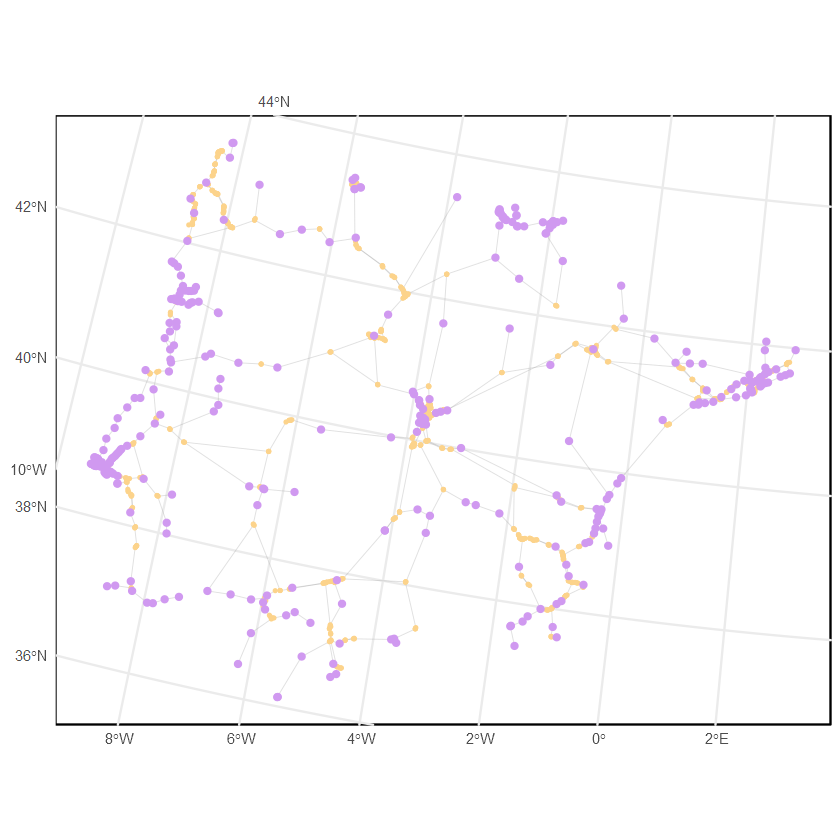

In [ ]:

# 3) Now just call your plotting function
plot_rail_graph(
  graph         = final_g,        # or whatever igraph object you want
  coord_dictionary,
  id_stations   = stations_id,
  epsg          = 3035,            # or your CRS of choice
  edge_colour   = "grey60",
  other_colour  = "#FCD38B",
  station_colour= "#D099F0",
  vertex_size   = 0.4,
  station_scale = 3.2,
  width         = 7,
  height        = 6,
  dpi           = 300,
  file          = NULL             # or "rail.png"
)

### Gmaps sanity check an unused functions

In [87]:
coords_stations_gmaps <- coords_stations %>%
  mutate(
    # build a “lat,lon” text column
    gmaps = sprintf("%.6f,%.6f", lat, lon),
    # and, if you like, a full URL
    gmaps_url = paste0("https://www.google.com/maps?q=", gmaps)
  )

# Preview the first few
head(coords_stations_gmaps[coords_stations_gmaps$ICC == 'BG',])

lon,lat,ICC,NAMN1,RStationID,TFC,gmaps,gmaps_url
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
23.23575,43.82268,BG,Лом,N.BG.RAILRDC.000222,0,"43.822681,23.235754","https://www.google.com/maps?q=43.822681,23.235754"
23.07077,43.67126,BG,Брусарци,N.BG.RAILRDC.000212,0,"43.671265,23.070768","https://www.google.com/maps?q=43.671265,23.070768"
22.86109,43.98157,BG,Видин,N.BG.RAILRDC.000219,0,"43.981571,22.861087","https://www.google.com/maps?q=43.981571,22.861087"
22.89233,44.01845,BG,Капитановци,N.BG.RAILRDC.000220,0,"44.018448,22.892325","https://www.google.com/maps?q=44.018448,22.892325"
23.03319,44.07114,BG,Кошава,N.BG.RAILRDC.000221,0,"44.071136,23.033193","https://www.google.com/maps?q=44.071136,23.033193"
22.97098,43.69198,BG,Дреновец,N.BG.RAILRDC.000213,0,"43.691978,22.970981","https://www.google.com/maps?q=43.691978,22.970981"


#### before and after

before

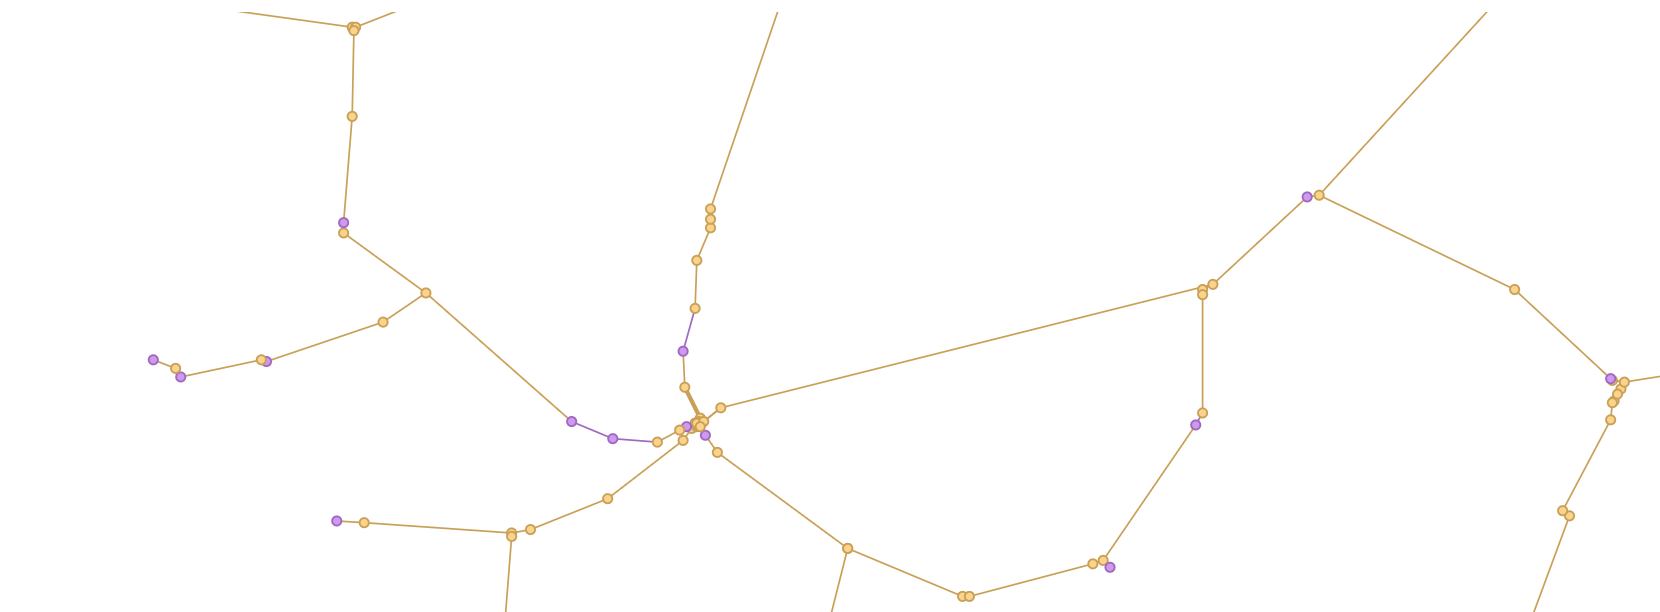


after

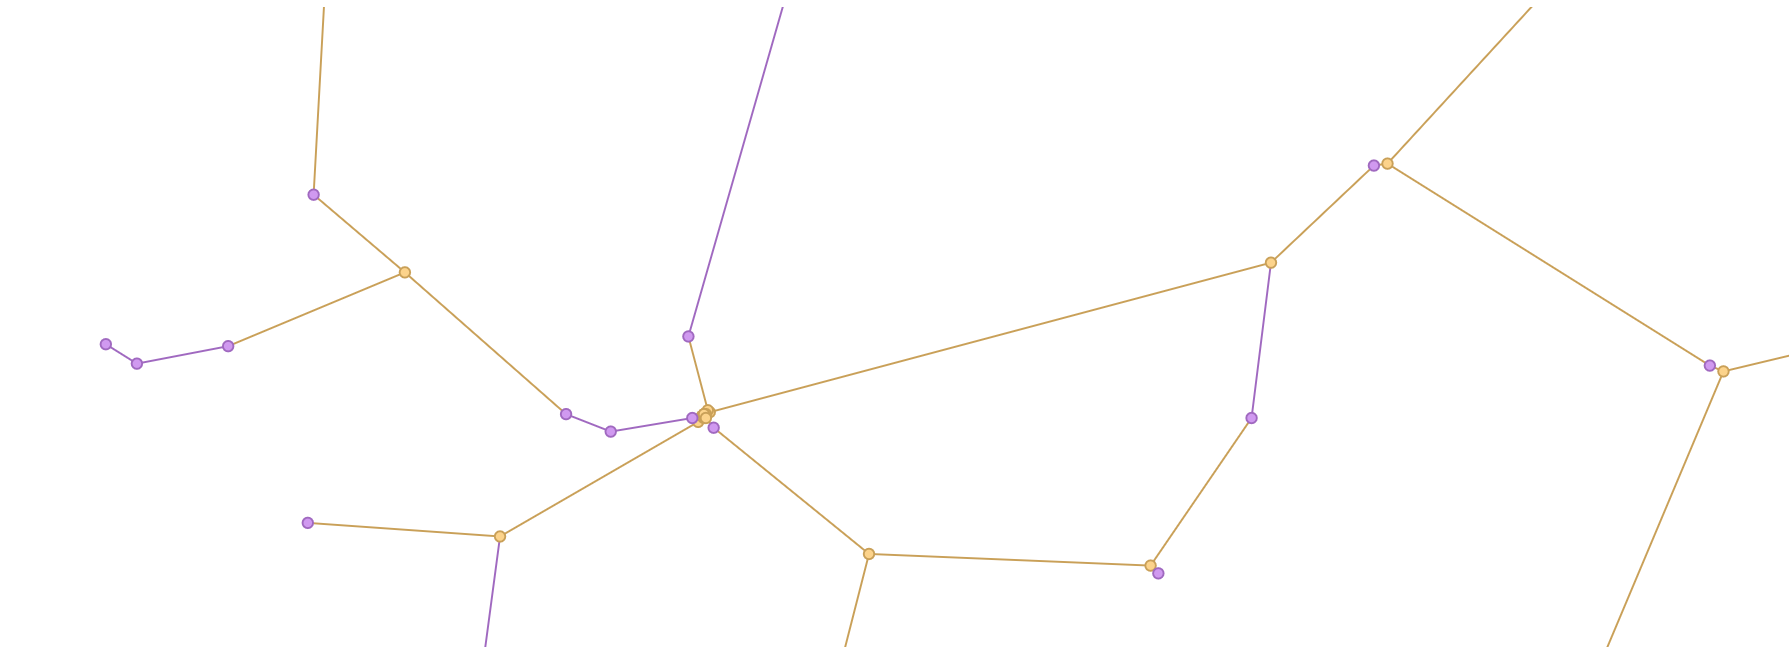

In [293]:
classify_junction <- function(graph, coords, v,tol) {
  # graph: igraph object
  # coords: data.frame with columns id, x, y
  # v: vertex id (matching V(graph)$name)
  
  nbrs <- neighbors(graph, v)$name
  if (length(nbrs) != 3) stop("only for degree-3 nodes")
  
  # get vectors
  xy_v <- coords[coords$id == v, c("x","y")]
  vecs <- t(sapply(nbrs, function(u) {
    xy_u <- coords[coords$id == u, c("x","y")]
    as.numeric(xy_u - xy_v)
  }))
  
  # pairwise angles
  angles <- c(
    acos( sum(vecs[1,]*vecs[2,]) / (sqrt(sum(vecs[1,]^2))*sqrt(sum(vecs[2,]^2))) ),
    acos( sum(vecs[1,]*vecs[3,]) / (sqrt(sum(vecs[1,]^2))*sqrt(sum(vecs[3,]^2))) ),
    acos( sum(vecs[2,]*vecs[3,]) / (sqrt(sum(vecs[2,]^2))*sqrt(sum(vecs[3,]^2))) )
  )
  
  # classification
  if (all(abs(angles - 2*pi/3) < tol)) {
    return("Y-junction")
  } else if (any(angles > pi - tol) && sum(angles < pi/3 + tol) == 2) {
    return("T-junction")
  } else {
    return("other")
  }
}
classify_all_junctions <- function(graph, coords, tol = 30 * pi/180) {
  # 1) get all degree-3 vertex names (as strings)
  deg3_names <- V(graph)[degree(graph) == 3]$name
  
  # short-circuit: nothing to do
  if (length(deg3_names) == 0) {
    return(data.frame(id = character(0), type = character(0),
                      stringsAsFactors = FALSE))
  }
  
  # 2) classify each one
  types <- sapply(deg3_names, function(v_name) {
    # classify_junction expects a numeric 'v'
    classify_junction(graph, coords, as.numeric(v_name), tol)
  }, USE.NAMES = FALSE)
  
  # 3) bundle into a data.frame
  data.frame(
    id   = deg3_names,
    type = types,
    stringsAsFactors = FALSE,
    row.names = NULL
  )
}

In [360]:
compute_junction_angles <- function(center, neighbors, coords, unit = c("rad","deg")) {
  unit <- match.arg(unit)
  
  # 0) sanity checks
  if (length(neighbors) != 3) {
    stop("`neighbors` must be a vector of exactly three node IDs.")
  }
  # extract center coords
  xy_c <- coords[ coords$id == center, c("x","y") ]
  if (nrow(xy_c) != 1) {
    stop("Center node ", center, " not found (or not unique) in coords.")
  }
  # extract neighbour coords (and preserve order)
  idx    <- match(neighbors, coords$id)
  if (any(is.na(idx))) {
    stop("Some neighbor IDs not found in coords: ",
         paste(neighbors[is.na(idx)], collapse = ", "))
  }
  xy_n   <- coords[idx, c("x","y")]
  
  # 1) build the three vectors from center → each neighbour
  vecs <- t( apply(xy_n, 1, function(pt) pt - as.numeric(xy_c)) )
  #    vecs[1,] = vector to neighbors[1], etc.
  
  # 2) helper to get the angle between two vectors
  angle_rad <- function(u, v) {
    dot  <- sum(u * v)
    norm <- sqrt(sum(u^2)) * sqrt(sum(v^2))
    acos(pmax(pmin(dot/norm, 1), -1))
  }
  
  # 3) pairwise angles
  θ12 <- angle_rad(vecs[1,], vecs[2,])
  θ13 <- angle_rad(vecs[1,], vecs[3,])
  θ23 <- angle_rad(vecs[2,], vecs[3,])
  
  # 4) convert if needed
  if (unit == "deg") {
    θ12 <- θ12 * 180 / pi
    θ13 <- θ13 * 180 / pi
    θ23 <- θ23 * 180 / pi
  }
  
  # 5) return a named vector
  names(θ12) <- paste0("θ_", neighbors[1], neighbors[2])
  names(θ13) <- paste0("θ_", neighbors[1], neighbors[3])
  names(θ23) <- paste0("θ_", neighbors[2], neighbors[3])
  c(θ12, θ13, θ23)
}

#### remove 3 cliques

In [115]:
remove_triangle_intersections<- function(graph,id_stations){
    non_station_ids <- V(graph)[!(V(graph)$name %in% id_stations)]$name
    #questa mi crea un sottografo composto solo dai nodi il cui nome gli fornisco nel secondo argomento
    no_stations_subgraph <- induced_subgraph(graph, vids = non_station_ids)

    triangle_list <- cliques(no_stations_subgraph,min=3,max=3)
    notri_graph<- graph
    nodes_to_remove<-character(0)
    for (i in 1:length(triangle_list)){

        row <- triangle_list[[i]]
        #print(row)
        #print(names(row))
        row_names <- V(no_stations_subgraph)[row]$name
        neighbours_list <- adjacent_vertices(graph,row_names)
        #print(neighbours_list)

        
        if (all(sapply(neighbours_list, length) == 3)){
            #print('ciai')
            caccapupu<-character(0)
            for (k in 1:3){
                caccapupu<-c(caccapupu,neighbours_list[[k]])
                
            }
            caccapupu <- names (caccapupu)

            not_in_row <- setdiff(caccapupu, names(row))
        
        
        new_edges <- combn(not_in_row, 2, simplify = TRUE)
        #print(new_edges)
        new_edges <- as.vector(new_edges)
        #print(new_edges)
        # Add these edges to the graph
        notri_graph <- add_edges(notri_graph, new_edges)
        nodes_to_remove <- c(nodes_to_remove,names(row))
        }
    }
    all_nodes <- V(graph)$name
    nodes_to_keep <- all_nodes[!(all_nodes %in% nodes_to_remove)]
    notri_graph <- induced_subgraph(notri_graph,nodes_to_keep)
    return(notri_graph)
}


#### before and after

before

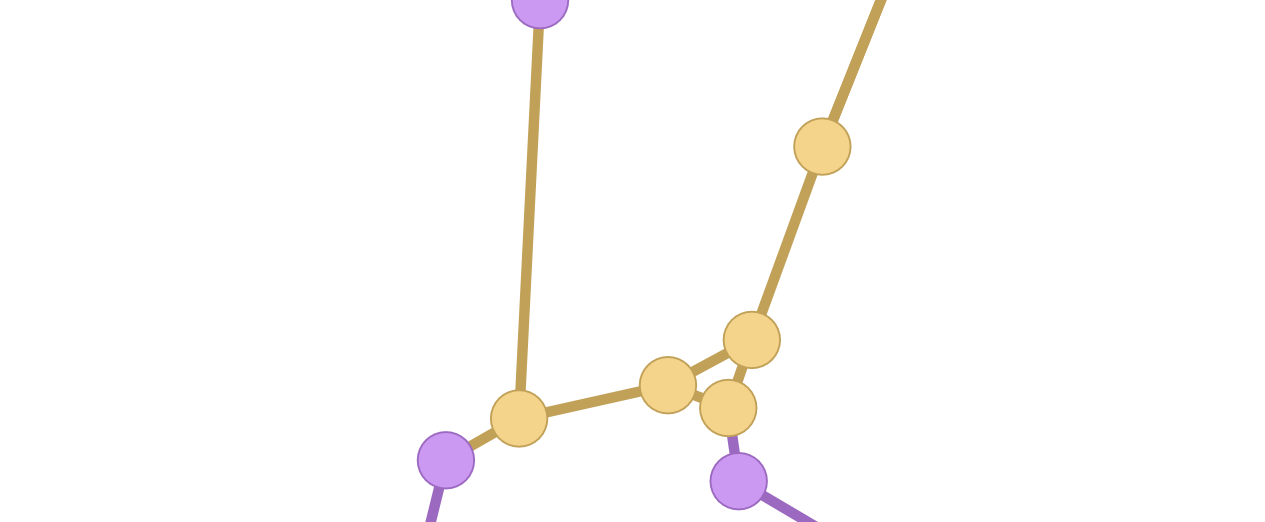

after

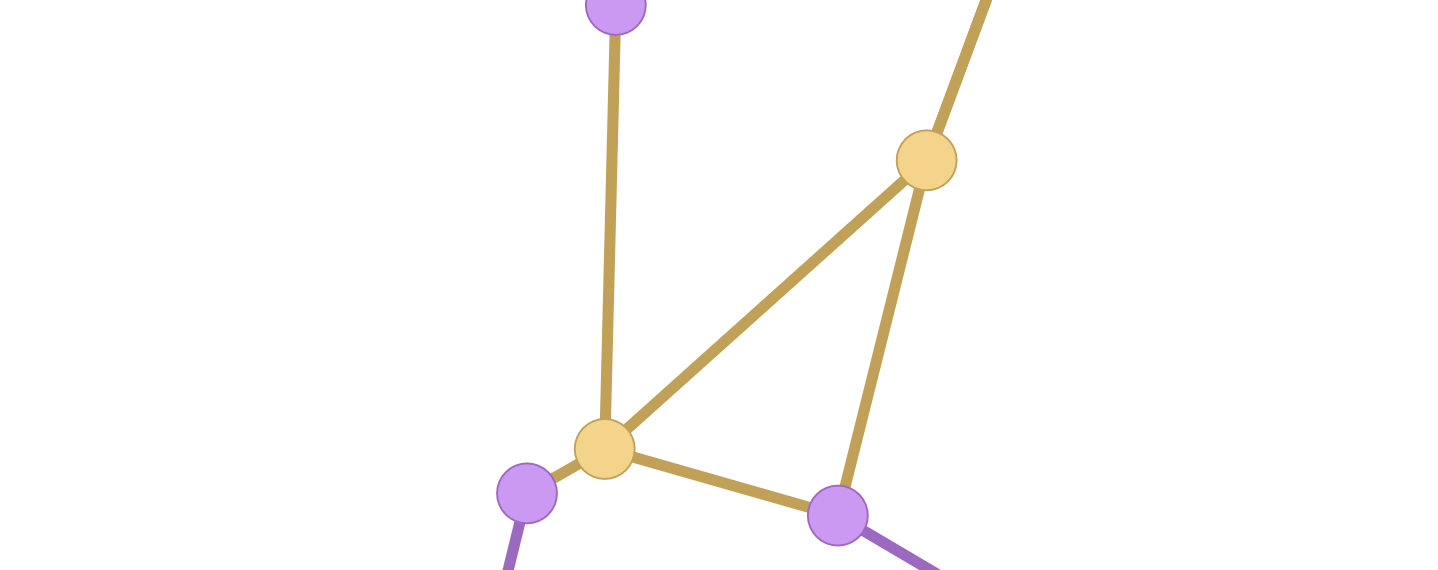

#### function to address isolated multi_degree stations

In [46]:
remove_intersections_close_to_station <- function(graph,id_stations, dictionary){
    nodes_to_remove <- as.character(0)
    for (node in id_stations){
        
        node <-as.character(node)
        neighbours <- names(neighbors(graph, node))
        
        nonstat_neig <- neighbours[!(neighbours %in% as.character(id_stations))]
        
        if(length(nonstat_neig)==0){next}
        for (neig in nonstat_neig){
            
            if (distHaversine(c(dictionary$x[dictionary$id ==node], dictionary$y[dictionary$id ==node]),
                              c(dictionary$x[dictionary$id ==neig], dictionary$y[dictionary$id ==neig]),
                              r = r_world)<4000){


                neig_neig <- names(neighbors(graph, neig))
                neig_neig <- neig_neig[neig_neig !=node]
                
                
                
                distances <- sapply(neig_neig, function(nn) {
                    distHaversine(
                        c(dictionary$x[dictionary$id == nn], dictionary$y[dictionary$id == nn]),
                        c(dictionary$x[dictionary$id == neig], dictionary$y[dictionary$id == neig]),
                        r = r_world
                    )
                })
                if (all(distances>5000)){ 
                    for (nn in neig_neig) {
                        graph <- add_edges(graph, c(node, nn))
                    }
                    nodes_to_remove <-c(nodes_to_remove,neig)
                }
                
                }        
        }
        

    }
    all_nodes <- V(graph)$name
    nodes_to_keep <- all_nodes[!(all_nodes %in% nodes_to_remove)]
    graph <- induced_subgraph(graph,nodes_to_keep)
    return(graph)
}


#### before and after

before

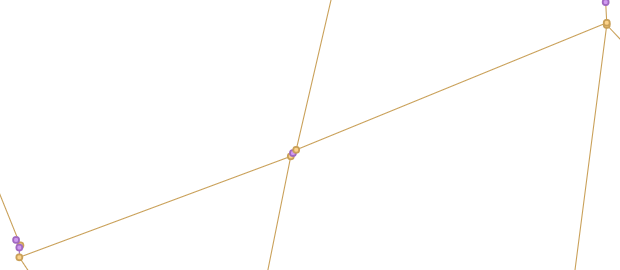


after

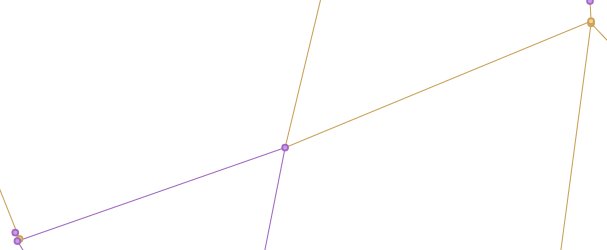

In [105]:
#questa funzione prendo un grafo e le stazioni, individua i clusters di nodi non stazioni e rimuovili, creando i link con la regola dei primi vicini
find_new_edges <- function(graph, id_stations) {
    
    non_station_id <- V(graph)[!(V(graph)$name %in% id_stations)]$name
    #questa mi crea un sottografo composto solo dai nodi il cui nome gli fornisco nel secondo argomento
    no_stations_subgraph <- induced_subgraph(graph, vids = non_station_id) # questo è un grafo fatto da parti sconnesse tra loro, per plottarlo devi usare le funzioni aggiuornate che ci stanno alla fine
    #ora uso la funzione clusters che stavi usando l'altra volta, chat mi dice che components è la stessa ma più nuova
    number_of_clusters <- components(no_stations_subgraph)$no
    isolated_clusters_info <-components(no_stations_subgraph)$membership

    #apro un for su tutti i clusters
    new_edges <- matrix(character(0), nrow = 2, ncol = 0)
    
    for (z in 1:number_of_clusters){
        cluster_members <- names(which(isolated_clusters_info == z)) # nome dei nodi che appartengono al cluster z
        
        ciao <- as.matrix(names(unlist(adjacent_vertices (graph,as.character(cluster_members)))))

        split_list <- strsplit(ciao, split = "\\.")

        # Convert the list to a matrix
        split_matrix <- do.call(rbind, split_list)
        neighbours_list <- as.character(unique(split_matrix)  )   #ora filtro per selezionare solo quelli che sono anche stazioni
        station_neighbours_list <- neighbours_list[neighbours_list %in% id_stations]
        
        if(length(station_neighbours_list) == 1 || length(station_neighbours_list) == 0 ){
            next
        }      
        else{   
            
            cluster_edges <- combn(station_neighbours_list, 2)
            print(cluster_edges)
            new_edges <- cbind(new_edges, cluster_edges)
        }

    }

    return(new_edges)
}